# Setup

In [1]:
# NOTE: This job does not work well in vscode
# PLEASE execute the ipynb file on the browser by ''jupyter notebook'', rather than in vscode.

import os
import time
import torch
import matplotlib

import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt

from tqdm import tqdm

# Ramachandran plot

## Configurations

In [2]:
# Molecule configs
molecule = "alanine"
start_state="c5"
end_state="c7ax"

# Path configs
project = "alanine"
date = "0517"
seed = "2"
md_file = f"../data/{molecule}/{start_state}.pdb"

# Image config
IMAGE_SIZE = "400px"

In [3]:
# NOTE: Modify this considering paths!!

# path to save the images
path_to_save = f"./" 

# Number of paths you will be drawing
path_num_max = 16

# FIle name of ramachandran plot
ram_filename = "ram"

## Predefined class, functions (you don't need to modify it)

In [4]:
# Alaninde potential from PIPS

class AlaninePotential():
    def __init__(self):
        super().__init__()
        self.open_file()

    def open_file(self):
        file = "../src/utils/alanine.dat"

        with open(file) as f:
            lines = f.readlines()

        dims = [90, 90]

        self.locations = torch.zeros((int(dims[0]), int(dims[1]), 2))
        self.data = torch.zeros((int(dims[0]), int(dims[1])))

        i = 0
        for line in lines[1:]:

            splits = line[0:-1].split(" ")
            vals = [y for y in splits if y != '']

            x = float(vals[0])
            y = float(vals[1])
            val = float(vals[-1])

            self.locations[i // 90, i % 90, :] = torch.tensor([x, y])
            self.data[i // 90, i % 90] = (val)  # / 503.)
            i = i + 1

    def potential(self, inp):
        loc = self.locations.view(-1, 2)
        distances = torch.cdist(inp, loc.double(), p=2)
        index = distances.argmin(dim=1)

        x = torch.div(index, self.locations.shape[0], rounding_mode='trunc')  # index // self.locations.shape[0]
        y = index % self.locations.shape[0]

        z = self.data[x, y]
        return z

In [5]:
# Helper functions

def compute_dihedral(p): 
    b = p[:-1] - p[1:]
    b[0] *= -1
    v = np.array(
        [v - (v.dot(b[1]) / b[1].dot(b[1])) * b[1] for v in [b[0], b[2]]])

    v /= np.sqrt(np.einsum('...i,...i', v, v)).reshape(-1, 1)
    b1 = b[1] / np.linalg.norm(b[1])
    x = np.dot(v[0], v[1])
    m = np.cross(v[0], b1)
    y = np.dot(m, v[1])
    return np.arctan2(y, x)

def plot_alanine_ram(dir_path, positions, last_idx, highlight_idx, filename="alanine", filetype="pdf"):
    # Basic configs
    plt.clf()
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    plt.xlim([-np.pi, np.pi])
    plt.ylim([-np.pi, np.pi])
    circle_size = 1200
    saddle_size = 2400
    z_num = 32

    # Plot potential by contour plot
    potential = AlaninePotential()
    xs = np.arange(-np.pi, np.pi + .1, .1)
    ys = np.arange(-np.pi, np.pi + .1, .1)
    x, y = np.meshgrid(xs, ys)
    inp = torch.tensor(np.array([x, y])).view(2, -1).T
    z = potential.potential(inp)
    z = z.view(y.shape[0], y.shape[1])
    plt.contourf(xs, ys, z, levels=z_num, zorder=0)

    # Plot start and target positions
    angle_1 = [6, 8, 14, 16]
    angle_2 = [1, 6, 8, 14]
    phi_start, psi_start = -2.45, 2.71
    phi_end, psi_end = 1.00, -0.65
    ax.scatter(phi_start, psi_start, edgecolors='black', c='w', zorder=z_num, s=circle_size)
    ax.scatter(phi_end, psi_end, edgecolors='black', c='w', zorder=z_num, s=circle_size)

    # Plot saddle points
    phis_saddle = [-0.035, -0.017]
    psis_saddle = [1.605, -0.535]
    ax.scatter(phis_saddle, psis_saddle, edgecolors='black', c='w', zorder=z_num, s=saddle_size, marker="*")
    
    # Plot paths
    cm = plt.get_cmap('gist_rainbow')
    ax.set_prop_cycle(color=[cm(1. * i / len(highlight_idx)) for i in range(len(highlight_idx))])
    for i in tqdm(range(len(positions))):
        if i in highlight_idx:
            psi = []
            phi = []
            for j in range(last_idx[i]):
                psi.append(compute_dihedral(positions[i][j][angle_1]))
                phi.append(compute_dihedral(positions[i][j][angle_2]))
            ax.plot(phi, psi, marker='o', linestyle='None', markersize=2, alpha=1., zorder=z_num-1)
        else:
            psi = []
            phi = []
            for j in range(last_idx[i]):
                psi.append(compute_dihedral(positions[i][j][angle_1]))
                phi.append(compute_dihedral(positions[i][j][angle_2]))
            ax.plot(phi, psi, marker='o', linestyle='None', markersize=2, alpha=0.1, color="grey")

    # Plot basic configs
    plt.xlabel('\u03A6', fontsize=24, fontweight='medium')
    plt.ylabel('\u03A8', fontsize=24, fontweight='medium')
    plt.tick_params(
        left = False,
        right = False ,
        labelleft = False , 
        labelbottom = False,
        bottom = False
    ) 
    plt.tight_layout()
    
    # Save figure
    if filetype.lower() not in ["pdf", "png", "jpg", "jpeg"]:
        raise ValueError("Invalid file type. Please use pdf, png, jpg, or jpeg.")
    file_name = f"{dir_path}/{filename}.{filetype}"
    fig.savefig(file_name, dpi=300)
    plt.show()
    print(f"File saved at {file_name}!!")
    
    return fig

## Plot!

In [6]:
# Select paths
positions_list = []
path_length_list = []

# Select paths to highlight, if needed
# highlight = [1, 11, 19, 33, 35, 40, 41, 44, 45, 49, 54, 59]
highlight = [i for i in range(path_num_max)]

for path_num_idx in range(path_num_max):
    # traj_file_name = f"../results/{project}/{date}/eval/{seed}/3D/3D_view_{path_num_idx}.h5"
    traj_file_name = f"2/3D_views/{path_num_idx}.h5"
    traj = md.load(traj_file_name, top=md_file)
    positions_list.append(traj.xyz)
    path_length_list.append(traj.n_frames)

/home/guest_sky/.local/lib/python3.9/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/home/guest_sky/.local/lib/python3.9/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 18.18it/s]


<Figure size 640x480 with 0 Axes>

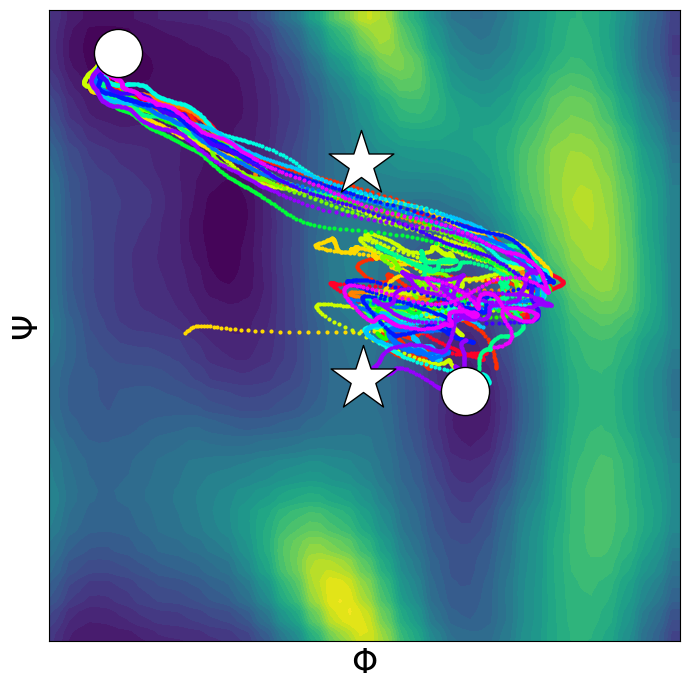

File saved at .//alanine_ram.pdf!!
16 paths highlighted!


In [7]:
# If file loading takes too long, use "png" instead of "pdf"
fig = plot_alanine_ram(
    dir_path = path_to_save,
    positions = positions_list,
    last_idx = path_length_list,
    highlight_idx = highlight,
    filename = ram_filename, 
    filetype = "pdf"
)
print(f"{len(highlight)} paths highlighted!")

# Values

## Configurations

In [8]:
colors = ["#A10035", "#3FA796", "#FEC220", "#2A0944"]

# NOTE:Select path num to plot!!
path_num = 8

## Torsion angles

In [9]:
# Load paths

# traj_file_name = f"../results/{molecule}/{project}/{date}/eval/{seed}/3D/3D_view_{path_num}.h5"
traj_file_name = "2/3D_views/0.h5"
traj = md.load(traj_file_name, top=md_file)

angle_1 = [6, 8, 14, 16]
angle_2 = [1, 6, 8, 14]

psi_list = traj.xyz[:, angle_1, :]
phi_list = traj.xyz[:, angle_2, :]
psi_list = [compute_dihedral(psi) for psi in psi_list]
phi_list = [compute_dihedral(phi) for phi in phi_list]

/home/guest_sky/.local/lib/python3.9/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [10]:
def plot_torsion_angle(image_name, path_to_save, data, color, y_label):
    # Basic configs
	fig = plt.figure(figsize=(20, 3))
	plt.plot(data, color = color,linewidth=4)
	plt.tick_params(
		left = True,
		right = False ,
		labelleft = True , 
		labelbottom = True,
		bottom = True
	) 
 
	# Data configs
	plt.ylim(-3.15, 3.15)
	plt.xlabel('Time (fs)', fontsize=18, weight="semibold")
	plt.ylabel(f"{y_label}", fontsize=18, weight="semibold")
	plt.xticks(fontsize=14, weight="semibold")
	plt.grid(axis='y')

	plt.tight_layout()
	fig.savefig(f'{path_to_save}/{image_name}.pdf', dpi=300)
	plt.show()
	plt.close()

	return fig

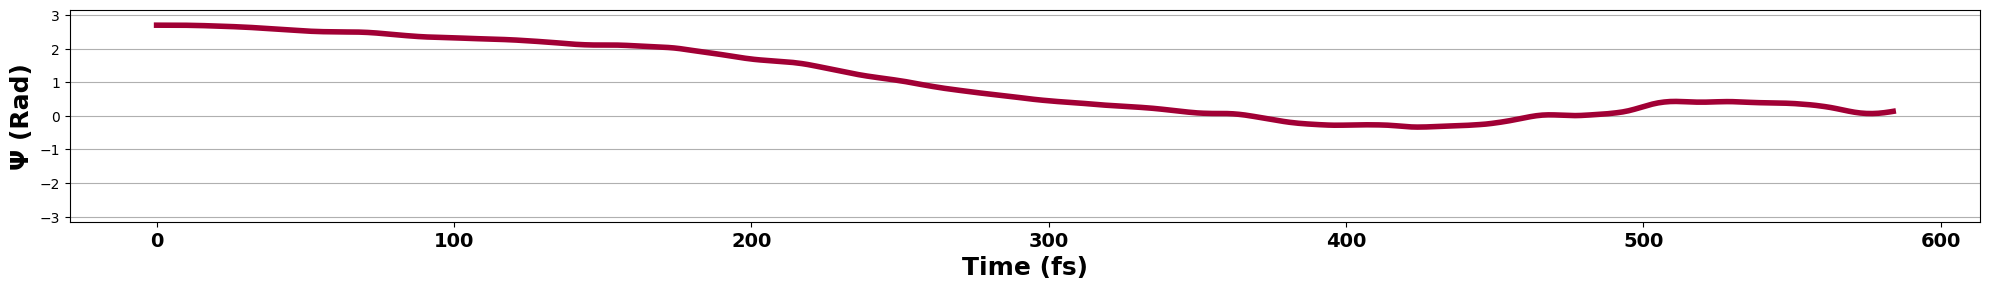

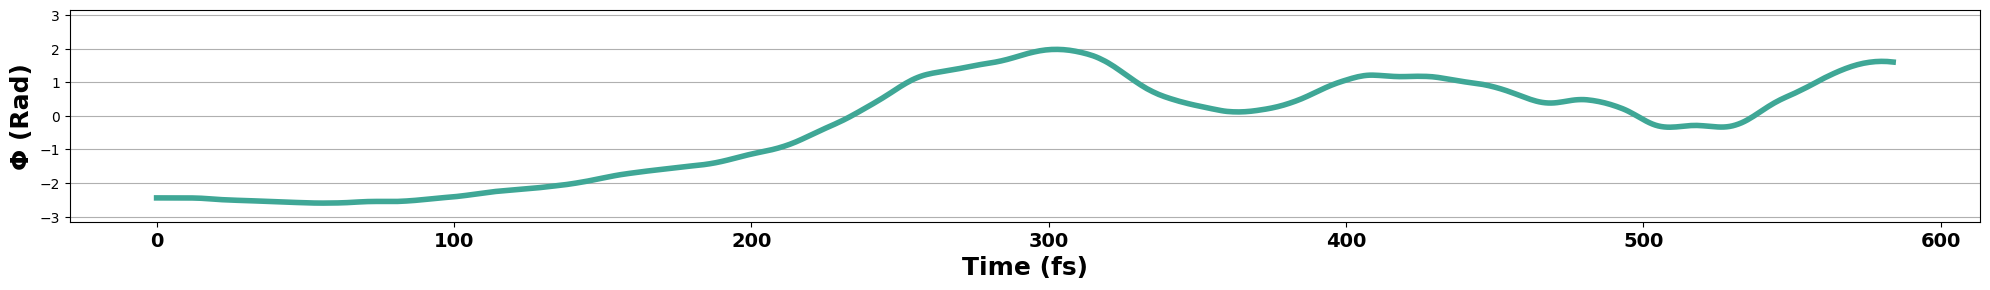

In [11]:
# Plot torsion angles
fig_psi = plot_torsion_angle(
	image_name = "psi",
	path_to_save = path_to_save,
	data = psi_list,
	color = colors[0],
	y_label = "\u03A8 (Rad)"
)
fig_psi = plot_torsion_angle(
	image_name = "phi",
	path_to_save = path_to_save,
	data = phi_list,
	color = colors[1],
	y_label = "\u03A6 (Rad)"
)

## Potential energy

In [12]:
# Load potential energy value from npy file
potential_file_name = f"../results/{molecule}/{project}/{date}/eval/{seed}/potential/potential_values_{path_num}.npy"

potential_data = np.load(potential_file_name)
potential_data.shape

FileNotFoundError: [Errno 2] No such file or directory: '../results/alanine/alanine/0517/eval/2/potential/potential_values_8.npy'

In [ ]:
def plot_potential(image_name, path_to_save, data, color, y_label):
    # Basic configs
	fig = plt.figure(figsize=(20, 5))
	plt.plot(data, color = color,linewidth=4)
	plt.tick_params(
		left = True,
		right = False ,
		labelleft = True , 
		labelbottom = True,
		bottom = True
	) 

	# Data configs
	plt.xlabel('Time (fs)', fontsize=28, weight="semibold")
	plt.ylabel(f"{y_label}", fontsize=28, weight="semibold")
	plt.xticks(fontsize=18, weight="semibold")
 	# NOTE: Modify this considering molecules!!
	plt.yticks([-1500, -1200, -900, -600], fontsize=18, weight="semibold")
	plt.grid(axis='y')

 	# Save figure
	plt.tight_layout()
	fig.savefig(f'{path_to_save}/{image_name}.pdf', dpi=300)
	plt.show()
	plt.close()

	return fig

In [ ]:
# Plot potential energy
fig_pot = plot_potential(
	image_name = "potential",
	path_to_save = path_to_save,
	data = potential_data,
	color = colors[3],
	y_label = "Potential Energy (kJ/mol)"
)